In [1]:
import pandas as pd
import utils
import matplotlib.pyplot as plt
import os
import dataloader

import torch
import torch.nn as nn
from model import generate_model

from torch.utils.data import DataLoader
from metrics import accuracy

d:\MyGit\CT_Classfication_Net\pymain\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dir_path ='result/' 
result_name = ['resnet18_20221216_1108'] #selector

selector = 0

result_path = os.path.join(dir_path,result_name[selector])
df_train_log = pd.read_csv(os.path.join(result_path,result_name[selector]+'_train.log'),delimiter='\t')
df_valid_log = pd.read_csv(os.path.join(result_path,result_name[selector]+'_valid.log'),delimiter='\t')
df_test_log = pd.read_csv(os.path.join(result_path,result_name[selector]+'_test.log'),delimiter='\t')

model_last_path = os.path.join(result_path,result_name[selector]+'_checkpoint.pth')
model_best_path = os.path.join(result_path,result_name[selector]+'_best.pth')

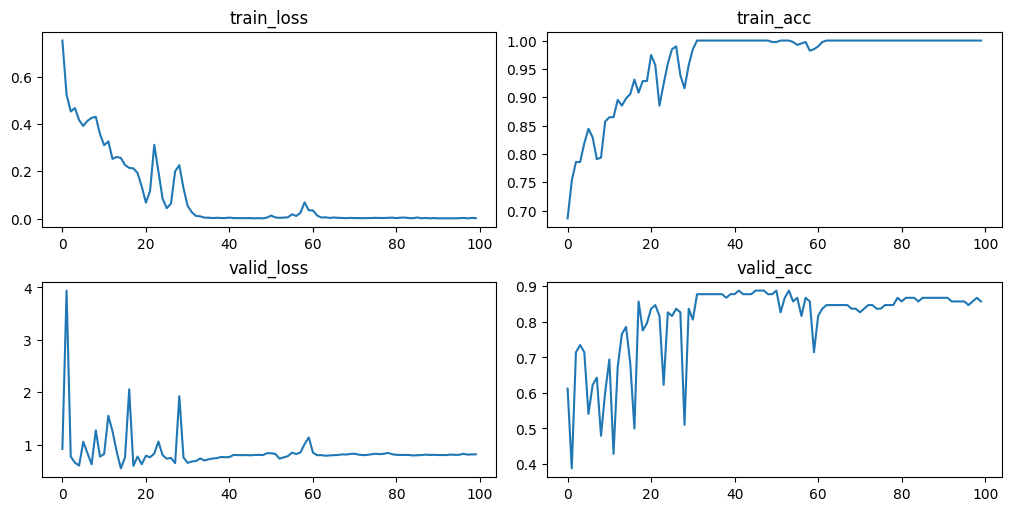

In [3]:
fig,ax = plt.subplots(2,2,figsize=[10,5],constrained_layout=True)
#plt.suptitle('title')
ax[0,0].set_title('train_loss')
ax[0,0].plot(df_train_log['loss'])
ax[0,1].set_title('train_acc')
ax[0,1].plot(df_train_log['acc'])
ax[1,0].set_title('valid_loss')
ax[1,0].plot(df_valid_log['loss'])
ax[1,1].set_title('valid_acc')
ax[1,1].plot(df_valid_log['acc'])
plt.savefig(os.path.join(result_path,'loss_acc_plot.png'))
plt.show()

In [4]:
config = utils.load_config()

df_dataset = pd.read_csv(config['DATASET_PATH'])
df_dataset = df_dataset.dropna().reset_index(drop=True)

from sklearn.model_selection import train_test_split
X = df_dataset.drop(labels='label',axis=1)
Y = df_dataset['label']

X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,shuffle=True,stratify=None,random_state=1004)

traindata=dataloader.CTDataset(X_train,y_train)
testdata=dataloader.CTDataset(X_test,y_test)

train_dataloader = DataLoader(traindata , batch_size=1, shuffle=True, sampler = None, num_workers=1,pin_memory = True)
test_dataloader = DataLoader(testdata , batch_size=1, shuffle=False, num_workers=1, pin_memory = True)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

add_last_fc_num = 0

model, _ = generate_model(model_name='resnet',model_depth = 18,n_classes=2,resnet_shortcut='B',add_last_fc_num=add_last_fc_num)
model.to(device)

criterion_clf = nn.CrossEntropyLoss().to(device)

checkpoint = torch.load(model_best_path, map_location=device)
model.load_state_dict(checkpoint['state_dict'])


cpu


d:\MyGit\CT_Classfication_Net\models\resnet.py:143: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')


<All keys matched successfully>

In [6]:
from model_test import test

test_internal_logger = utils.Logger(os.path.join(result_path, 'test(internal).log'),['best_yn','loss', 'acc','ConfusionMatrix','auroc','fpr','tpr','thresholds'])

in_loss, in_acc, in_CM, in_auroc, in_fpr, in_tpr, in_thresholds = test(device,test_dataloader,model,criterion_clf, test_internal_logger,best_yn=False)

test


98it [04:21,  2.67s/it]


Loss : 0.4702	 Acc : 0.94898	
tensor([[36,  2],
        [ 3, 57]])
tensor([0.9346, 0.9346])


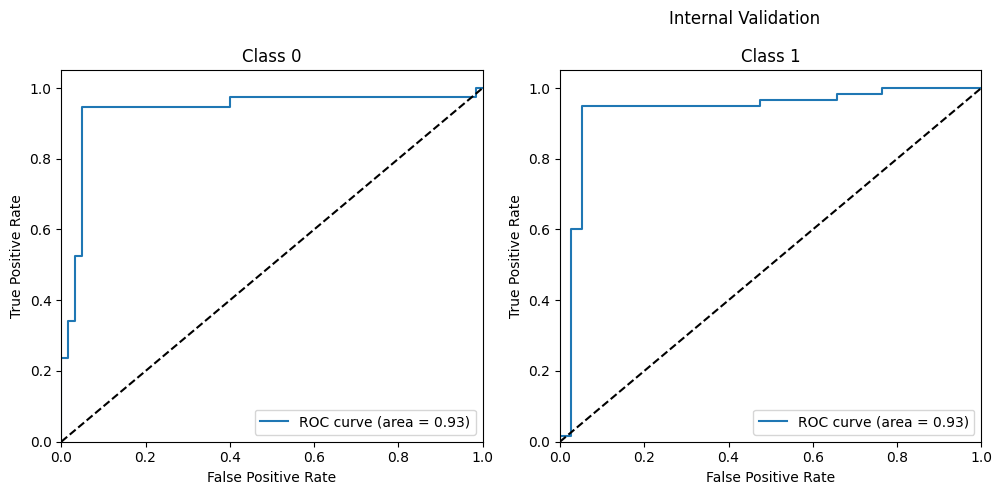

In [16]:
# Plot of a ROC curve for a specific class
plt.figure(figsize=(15, 5))
for idx, i in enumerate(range(2)):
    plt.subplot(131+idx)
    plt.plot(in_fpr[i], in_tpr[i], label='ROC curve (area = %0.2f)' % in_auroc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Class %0.0f' % idx)
    plt.legend(loc="lower right")

title = 'Internal Validation'
plt.suptitle(title)
plt.tight_layout()
plt.savefig(os.path.join(result_path,title+'.png'))
plt.show()

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from monai.visualize import matshow3d

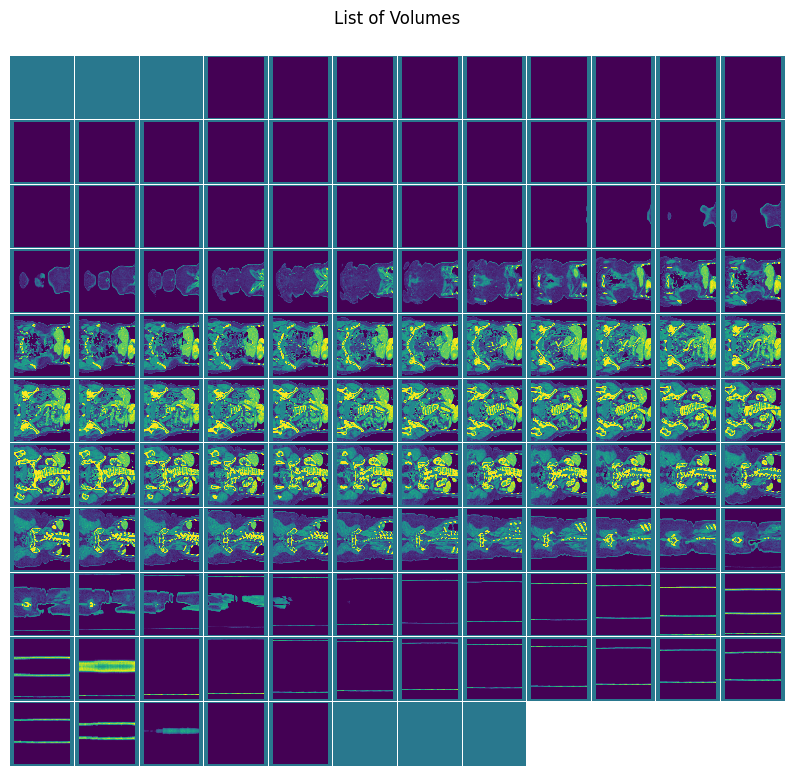

In [18]:
train_itera = iter(train_dataloader)
test_itera = iter(test_dataloader)

def get_next_im(iter):
    tmp_data = next(iter)
    return tmp_data[0].to(device), tmp_data[1].unsqueeze(0).to(device)


train_img, _ = get_next_im(train_itera)
test_img, _  = get_next_im(test_itera)

# create a figure of a list of channel-first 3D volumes
fig = plt.figure()
matshow3d([test_img], fig=fig, title="List of Volumes")
plt.show()

In [19]:
# resnet 2d
from monai.visualize import GradCAM,OcclusionSensitivity, CAM

grad_cam = GradCAM(nn_module=model, target_layers="layer4")
cam = CAM(nn_module=model, target_layers="layer4", fc_layers="fc")
occ_sens = OcclusionSensitivity(nn_module=model, mask_size=12, n_batch=1, stride=12)
#result = cam(x=torch.rand((2, 3, 48, 64)))

In [21]:
test_img.shape

torch.Size([1, 1, 128, 128, 128])

In [23]:
depth_slice = 50
occ_sens_b_box_1 = [depth_slice-1, depth_slice, -1, -1, -1, -1]
occ_sens_b_box_2 = [-1, -1, depth_slice-1, depth_slice, -1, -1]
occ_sens_b_box_3 = [-1, -1, -1, -1, depth_slice-1, depth_slice]
occ_result_1, _ = occ_sens(x=test_img, b_box=occ_sens_b_box_1)
occ_result_2, _ = occ_sens(x=test_img, b_box=occ_sens_b_box_2)
occ_result_3, _ = occ_sens(x=test_img, b_box=occ_sens_b_box_3)

print(occ_result_1.shape)
print(occ_result_2.shape)
print(occ_result_3.shape)

 26%|██▌       | 51/196 [00:44<02:13,  1.09it/s]

0
1


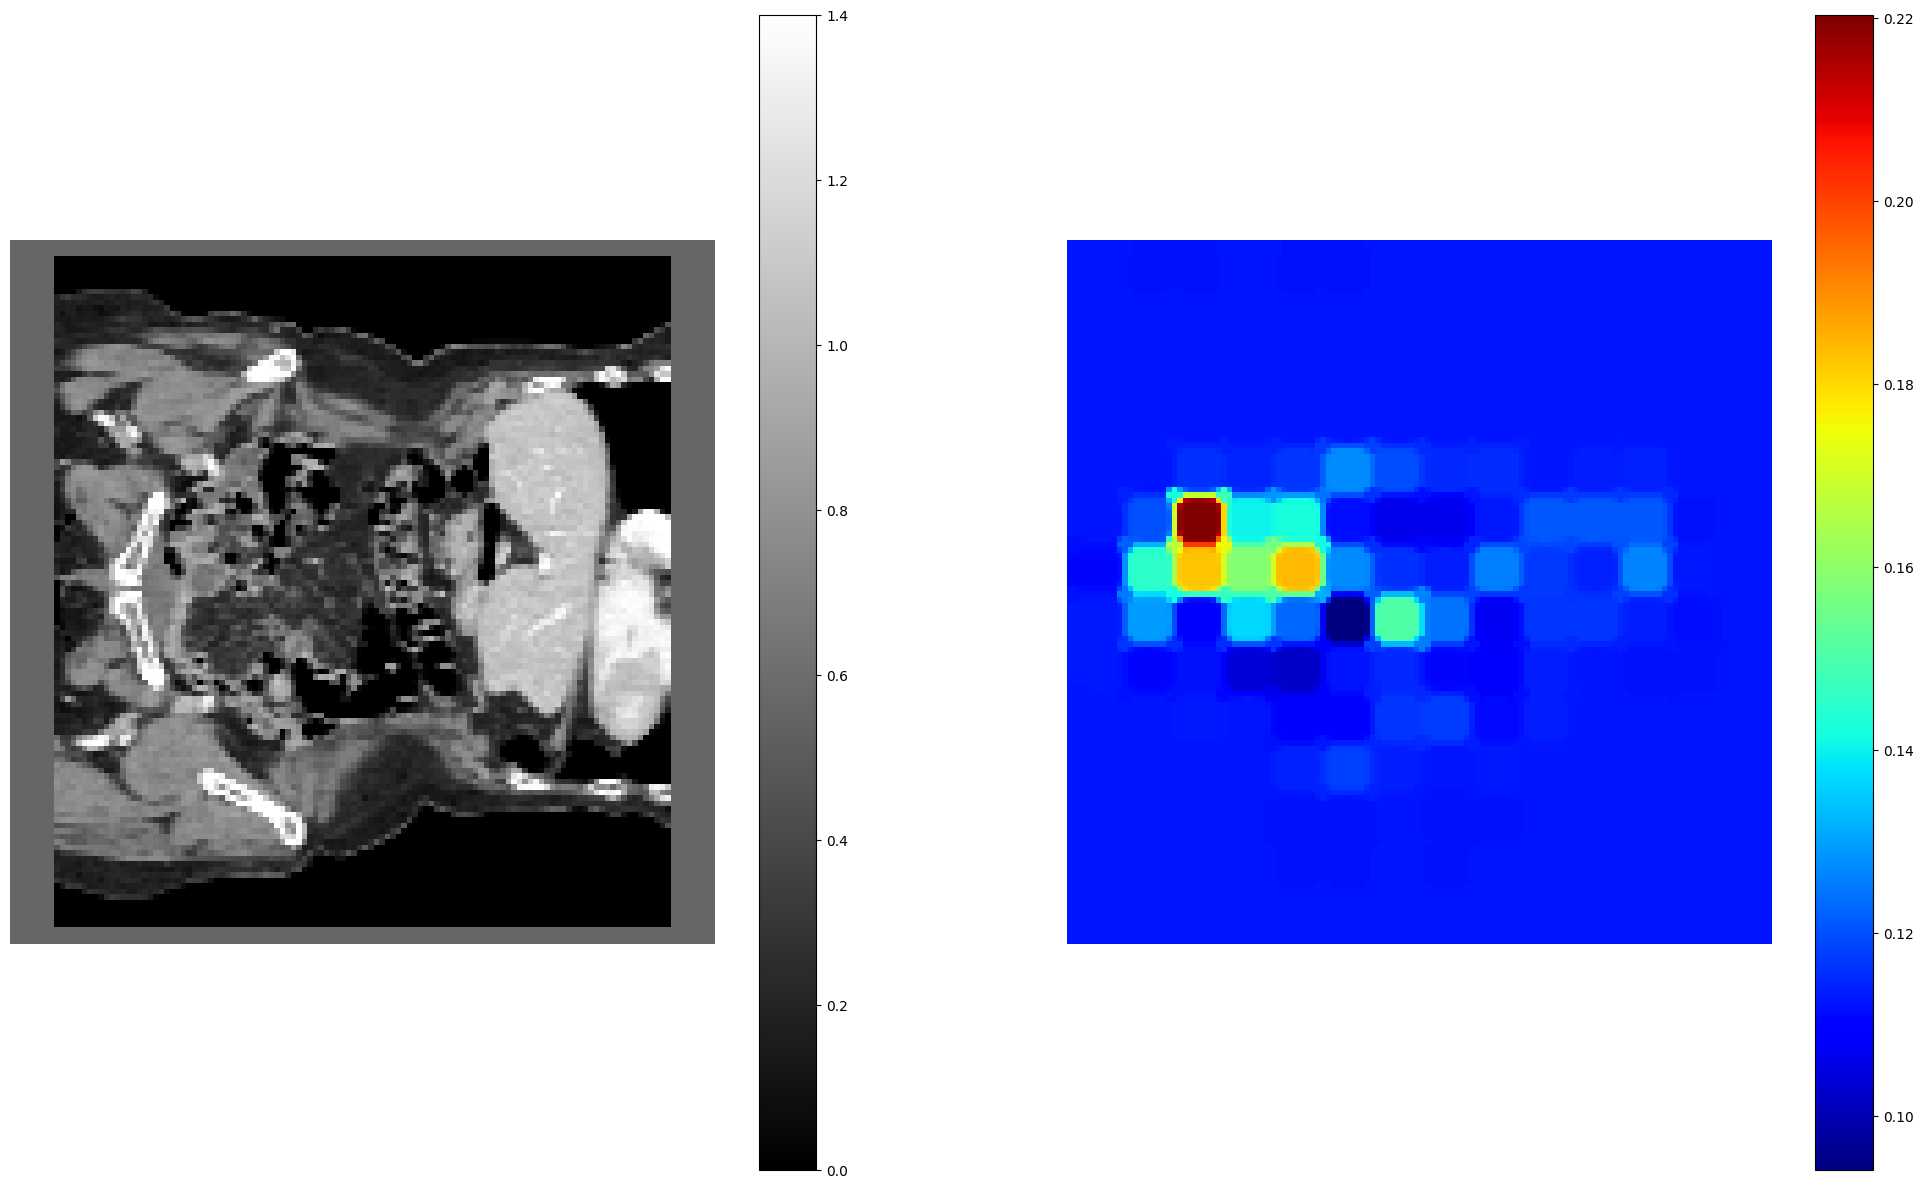

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(25, 15), facecolor="white")

for i, im in enumerate([test_img[:, :, depth_slice], occ_result]):
    cmap = "gray" if i == 0 else "jet"
    ax = axes[i]
    im_show = ax.imshow(np.squeeze(im[0][0].detach().cpu()), cmap=cmap)
    ax.axis("off")
    fig.colorbar(im_show, ax=ax)

In [13]:
test_img, _  = get_next_im(test_itera)
print(test_img.shape)

torch.Size([1, 1, 128, 128, 128])


In [14]:
depth_slice = 50
occ_sens_b_box = [depth_slice-1, depth_slice, -1, -1, -1, -1]
#occ_sens_b_box = [-1, -1, -1, -1, depth_slice-1, depth_slice]
occ_result, _ = occ_sens(x=test_img, b_box=occ_sens_b_box)
occ_result.shape

100%|██████████| 196/196 [02:25<00:00,  1.35it/s]


(1, 2, 1, 128, 128)

IndexError: index 50 is out of bounds for dimension 0 with size 1

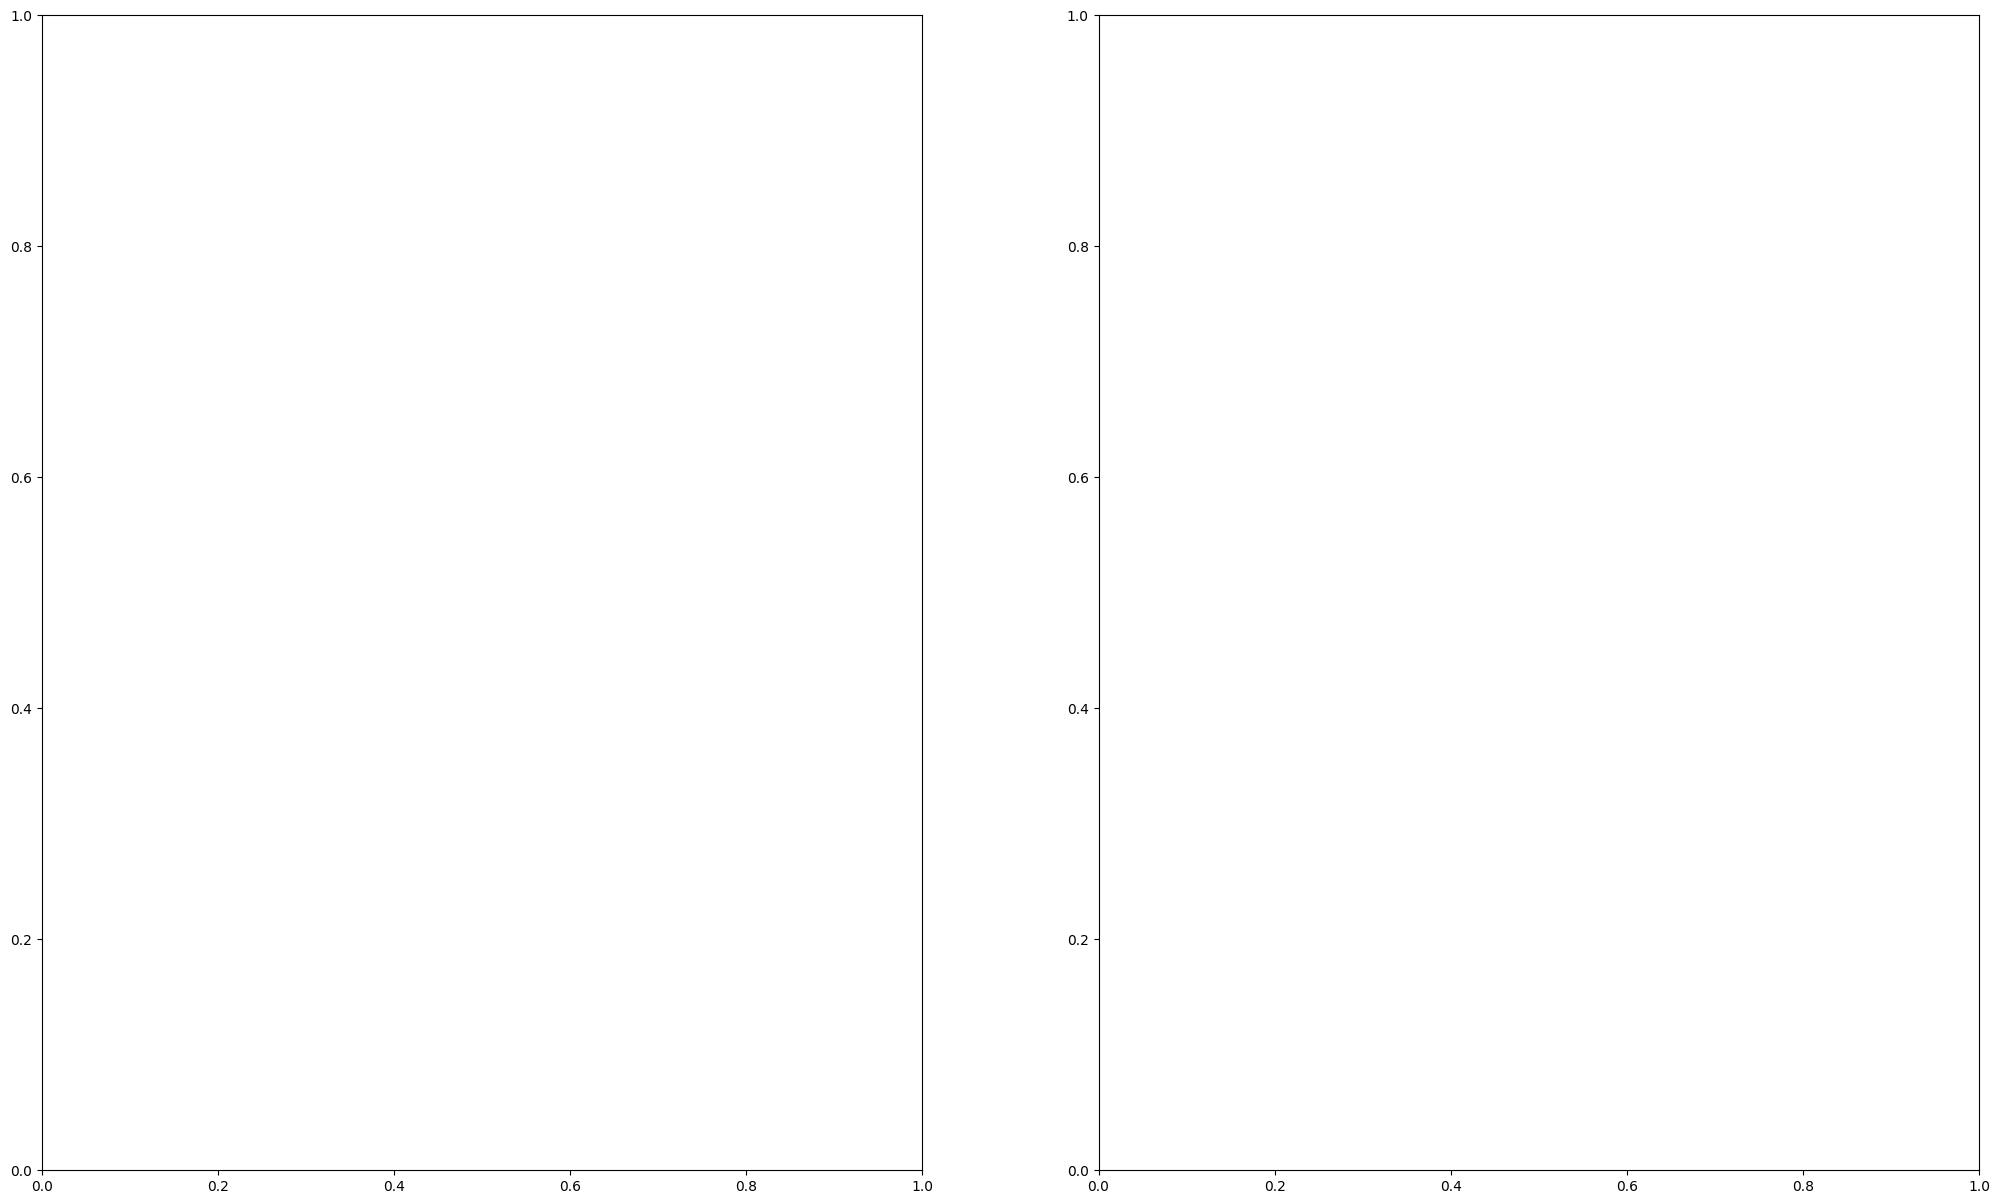

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(25, 15), facecolor="white")

for i, im in enumerate([test_img[depth_slice, :, :], occ_result]):
    cmap = "gray" if i == 0 else "jet"
    ax = axes[i]
    im_show = ax.imshow(np.squeeze(im[0][0].detach().cpu()), cmap=cmap)
    ax.axis("off")
    fig.colorbar(im_show, ax=ax)